# Anatomy of a Classification Problem

# Classifcation in the Real-World
This notebook aims to demonstrate how to approach an image classification problem in a real world way. 
Typically, real world applications have little data to work with. That however doesn't mean that there is nothing to work with.

## The Plan
1. Gather data.
In this case we will use a known dataset and take a subsample to mimic a small dataset.
2. Establish a baseline. 
Beyond the naive guessing strategy which gives an accuracy of 1/#classes (assuming the data is evenly distributed), we can create a very simple network using the least number of tricks at our disposal to set a lower bound on accuracy.
3. Augment the dataset. 
Using transformations on the images we can assume that the input is invarient to certain transforms. For instance a cat is still a cat if we rotate the picture. Using the ImageDataGenerator from the Keras API we can artificially enhance the number of samples in our date set. This serves as a means to regularize our model to keep it from over fitting.
4. Use a pretrained model.
Reuse the convolution base of a pre-trained model which was trained on the massive image-net dataset. Then add custom fully connected layers on top to complete the classifier. The idea behind this is to leverage the features extractions learned on the millions of images which should generalize well to other image recognition problems like this one.
5. Fine-tune a pretrained model.
After training custom layers on top of a pretrained model, fine tune the top convolutional layer to extract features that are fine tuned for the specific problem space that we are trying to solve.

First, let's setup our env.

In [1]:
%tensorflow_version 2.x
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

TensorFlow 2.x selected.


Start out by aquiring the the labelled data set that we would like to learn.

In [0]:
def get_dataset():
  return tfds.load(name='cats_vs_dogs', split=tfds.Split.TRAIN)
dataset = get_dataset()  

The data in this set has heterogenous tensor shapes. Need to:
* Process pixels in each channel to be in the range of [0.0,1.0]
* Make all images the same size

In [3]:
#Full dataset as numpy array

def preprocess(example):
  im = example['image']
  im = tf.image.convert_image_dtype(im, tf.float32)
  im = tf.image.resize(
    im,
    [150, 150],
    preserve_aspect_ratio=False)
  
  l = example['label']
  l = tf.dtypes.cast(l, tf.float32)

  return im, l

def get_dataset_as_numpy(size, offset):
  data = get_dataset().map(map_func=preprocess).skip(offset).take(size).batch(size)
  data_np = tfds.as_numpy(data)
  for im, l in data_np: 
    return im, l

x_train, y_train = get_dataset_as_numpy(2048, 0)
x_val, y_val = get_dataset_as_numpy(1024, 2048)
x_test, y_test = get_dataset_as_numpy(1024, 2048+1024)

print(x_train.shape)
print(x_train.dtype)
print(y_train.shape)
print(y_train.dtype)

print(x_train.max())
print(y_train.max())

print(x_train.min())
print(y_train.min())


(2048, 150, 150, 3)
float32
(2048,)
float32
1.0
1.0
0.0
0.0


##Visualize some samples in from the training data.

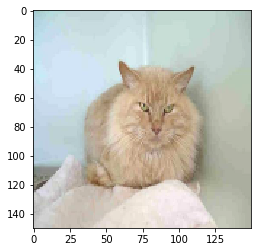

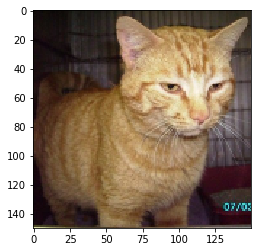

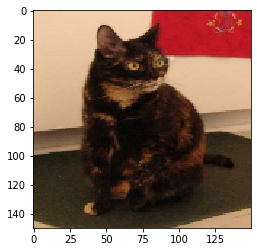

In [5]:
from tensorflow.keras.preprocessing import image

datagen = image.ImageDataGenerator()

i=0
for batch in datagen.flow(x_train, batch_size=1):
  plt.figure(i)
  imgplot = plt.imshow(image.array_to_img(batch[0]))
  i += 1
  if i == 3:
      break
plt.show()

## Create the a model for the baseline

In [13]:
from tensorflow.keras import models
from tensorflow.keras import layers

model = models.Sequential()
model.add(layers.Conv2D(
    32, (3, 3), 
    activation='relu',
    input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 128)       1

## Setup the optimizer
Use a binary cross entropy loss for the classifier since our output is a 
single value in the range of [0.0, 1.0] where 0 is a cat and 1 is a dog.
Could alternatively have used categorical cross entropy and make the 
output be a 2-vector where [1.0, 0.0] is a cat and [0.0, 1.0] is a dog.

In [0]:
# optimizer = tf.keras.optimizers.Adam(
#   learning_rate=0.001,
#   beta_1=0.9,
#   beta_2=0.999)
optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.0001)
model.compile(
  loss='binary_crossentropy',
  optimizer=optimizer,
  metrics=['acc'])

In [0]:
validation_datagen = image.ImageDataGenerator()
history = model.fit_generator(
  datagen.flow(x_train, y=y_train, batch_size=32),
  steps_per_epoch=64,
  epochs=30,
  validation_data=validation_datagen.flow(x_val, y=y_val, batch_size=32),
  validation_steps=32)

Epoch 1/30
64/64 [==============================] - 8s 125ms/step - loss: 0.6926 - acc: 0.5303 - val_loss: 0.6795 - val_acc: 0.5205
Epoch 2/30
64/64 [==============================] - 4s 67ms/step - loss: 0.6667 - acc: 0.6040 - val_loss: 0.6467 - val_acc: 0.6602
Epoch 3/30
64/64 [==============================] - 4s 68ms/step - loss: 0.6371 - acc: 0.6465 - val_loss: 0.6394 - val_acc: 0.6201
Epoch 4/30
64/64 [==============================] - 4s 68ms/step - loss: 0.6026 - acc: 0.6772 - val_loss: 0.5959 - val_acc: 0.6914
Epoch 5/30
64/64 [==============================] - 5s 72ms/step - loss: 0.5689 - acc: 0.7104 - val_loss: 0.5767 - val_acc: 0.7051
Epoch 6/30
64/64 [==============================] - 5s 72ms/step - loss: 0.5524 - acc: 0.7119 - val_loss: 0.5674 - val_acc: 0.7100
Epoch 7/30
64/64 [==============================] - 5s 78ms/step - loss: 0.5278 - acc: 0.7412 - val_loss: 0.5792 - val_acc: 0.6914
Epoch 8/30
64/64 [==============================] - 4s 69ms/step - loss: 0.5105 - 

## Result of the baseline.

Let's visualize the training outcome over each epoch.
Exact values may vary as each run has different randomly initialized weights.

However the trend is that this model very quickly overfits the data. 
With the training accuracy reaching 96% but the validation peaking at close to 
73%. We start overfitting right around the 5th epoch.

Running the model on the test set should give a similar result as the validation.

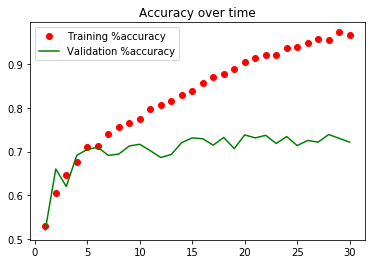

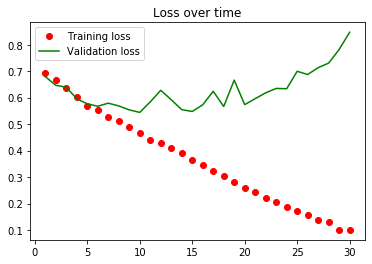

In [0]:
accuracy = history.history['acc']
validation_accuracy = history.history['val_acc']
training_loss = history.history['loss']
validation_loss = history.history['val_loss']
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, 'ro', label='Training %accuracy')
plt.plot(epochs, validation_accuracy, 'g', label='Validation %accuracy')
plt.title('Accuracy over time')
plt.legend()
plt.figure()
plt.plot(epochs, training_loss, 'ro', label='Training loss')
plt.plot(epochs, validation_loss, 'g', label='Validation loss')
plt.title('Loss over time')
plt.legend()
plt.show()

Let's save the model

In [0]:
model.save('baseline.h5')

In [0]:
from google.colab import files
files.download('baseline.h5')

KeyboardInterrupt: ignored

## Run on test data


In [0]:
predictions = model.predict(x_test)
print(predictions.shape)
print(y_test.shape)

predictions = predictions.reshape(y_test.shape)
print(predictions.shape)

difference = predictions - y_test
test_count = y_test.shape[0]
number_correct = 0

for i in range(test_count):
  d = difference[i]
  if (abs(d) < 0.5):
    number_correct += 1

print('Test accuracy = ' + str(number_correct/test_count*100) + '%')

(1028, 1)
(1028,)
(1028,)
Test accuracy = 76.26459143968872%


Nice! About 76% accuraty achieved on the test data. An improvement from 50% for
blindly guessing but we can do much better than that.

## Traing data augmentation

Let's improve the regularization of our model by adding dropout and 
augmenting the training data by applying random image tranformation
like resizing, rotation, and shear.

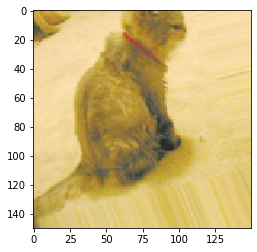

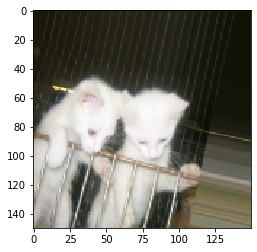

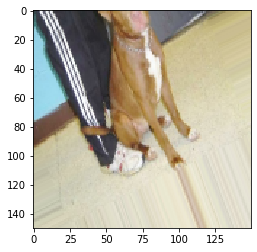

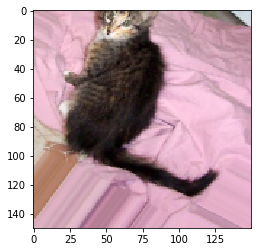

In [14]:
datagen = image.ImageDataGenerator(
  rotation_range=40,
  width_shift_range=0.2,
  height_shift_range=0.2,
  shear_range=0.2,
  zoom_range=0.2,
  horizontal_flip=True,
  fill_mode='nearest')

i=0
for batch in datagen.flow(x_train, batch_size=1):
    plt.figure(i)
    imgplot = plt.imshow(image.array_to_img(batch[0]))
    i += 1
    if i == 4:
        break
plt.show()

In [0]:
model = models.Sequential()

model.add(layers.Conv2D(
    32, 
    (3, 3),
    use_bias=False,
    input_shape=(150, 150, 3)))
model.add(layers.BatchNormalization())
model.add(layers.Activation("relu"))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), use_bias=False))
model.add(layers.BatchNormalization())
model.add(layers.Activation("relu"))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(128, (3, 3), use_bias=False))
model.add(layers.BatchNormalization())
model.add(layers.Activation("relu"))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(128, (3, 3), use_bias=False))
model.add(layers.BatchNormalization())
model.add(layers.Activation("relu"))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 148, 148, 32)      864       
_________________________________________________________________
batch_normalization (BatchNo (None, 148, 148, 32)      128       
_________________________________________________________________
activation (Activation)      (None, 148, 148, 32)      0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 72, 72, 64)        18432     
_________________________________________________________________
batch_normalization_1 (Batch (None, 72, 72, 64)        256       
_________________________________________________________________
activation_1 (Activation)    (None, 72, 72, 64)       

In [0]:
optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.0001)
model.compile(
  loss='binary_crossentropy',
  optimizer=optimizer,
  metrics=['acc'])

In [0]:
validation_datagen = image.ImageDataGenerator()
history = model.fit_generator(
  datagen.flow(x_train, y=y_train, batch_size=32),
  steps_per_epoch=64,
  epochs=5,
  validation_data=validation_datagen.flow(x_val, y=y_val, batch_size=32),
  validation_steps=32)

Epoch 1/5
64/64 [==============================] - 13s 197ms/step - loss: 0.4184 - acc: 0.8115 - val_loss: 0.3903 - val_acc: 0.8408
Epoch 2/5
64/64 [==============================] - 12s 188ms/step - loss: 0.4269 - acc: 0.8071 - val_loss: 0.4965 - val_acc: 0.7725
Epoch 3/5
64/64 [==============================] - 12s 188ms/step - loss: 0.4268 - acc: 0.7905 - val_loss: 0.5061 - val_acc: 0.7861
Epoch 4/5
64/64 [==============================] - 12s 184ms/step - loss: 0.4173 - acc: 0.8003 - val_loss: 0.5135 - val_acc: 0.7754
Epoch 5/5
64/64 [==============================] - 12s 182ms/step - loss: 0.4130 - acc: 0.8047 - val_loss: 0.4191 - val_acc: 0.8105


Visualize the results

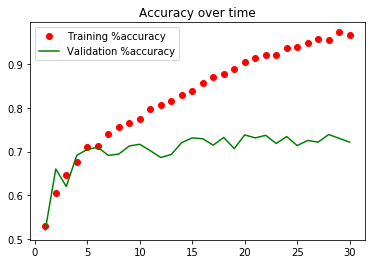

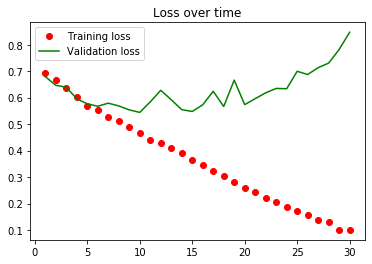

In [0]:
accuracy = history.history['acc']
validation_accuracy = history.history['val_acc']
training_loss = history.history['loss']
validation_loss = history.history['val_loss']
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, 'ro', label='Training %accuracy')
plt.plot(epochs, validation_accuracy, 'g', label='Validation %accuracy')
plt.title('Accuracy over time')
plt.legend()
plt.figure()
plt.plot(epochs, training_loss, 'ro', label='Training loss')
plt.plot(epochs, validation_loss, 'g', label='Validation loss')
plt.title('Loss over time')
plt.legend()
plt.show()

## Using a pretrained model

In [15]:
from tensorflow.keras.applications import ResNet50V2

base = ResNet50V2(
  weights='imagenet',
  include_top=False,
  input_shape=(150, 150, 3))
print(base.summary())

Model: "resnet50v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 156, 156, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 75, 75, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 77, 77, 64)   0           conv1_conv[0][0]                 
_________________________________________________________________________________________

## Feature extraction

To save on computation pass all of the training data through the pretrained model. Then train the custom model on top of it.

In [0]:
def extract_features(base_model, data_to_extract):
  return base_model.predict(data_to_extract)

In [17]:
simple_datagen = image.ImageDataGenerator()
print('samples in train')
print(x_train.shape[0])
extracted_train = extract_features(
  base,
  simple_datagen.flow(x_train, batch_size=x_train.shape[0], shuffle=False))
print(extracted_train.shape)

samples in train
2048
(2048, 5, 5, 2048)


In [18]:
extracted_val = extract_features(
  base,
  simple_datagen.flow(x_val, batch_size=x_val.shape[0], shuffle=False))
print(extracted_val.shape)

(1024, 5, 5, 2048)


In [19]:
extracted_test = extract_features(
  base,
  simple_datagen.flow(x_test, batch_size=x_test.shape[0], shuffle=False))
print(extracted_test.shape)

(1024, 5, 5, 2048)


In [20]:
custom_model = models.Sequential()
custom_model.add(layers.Flatten(input_shape=(5,5,2048)))
custom_model.add(layers.Dense(128, activation='relu', input_dim=5 * 5 * 2048))
custom_model.add(layers.Dropout(0.5))
custom_model.add(layers.Dense(1, activation='sigmoid'))

print(custom_model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 51200)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               6553728   
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 129       
Total params: 6,553,857
Trainable params: 6,553,857
Non-trainable params: 0
_________________________________________________________________
None


In [21]:
custom_model.compile(
  optimizer=tf.keras.optimizers.RMSprop(lr=0.000025),
  loss='binary_crossentropy',
  metrics=['acc'])
history = custom_model.fit(
  extracted_train, 
  y_train,
  epochs=30,
  batch_size=32,
  validation_data=(extracted_val, y_val))

Train on 2048 samples, validate on 1024 samples
Epoch 1/30
2048/2048 [==============================] - 1s 663us/sample - loss: 0.4042 - acc: 0.8940 - val_loss: 0.1576 - val_acc: 0.9463
Epoch 2/30
2048/2048 [==============================] - 1s 272us/sample - loss: 0.1209 - acc: 0.9561 - val_loss: 0.1295 - val_acc: 0.9482
Epoch 3/30
2048/2048 [==============================] - 1s 275us/sample - loss: 0.0633 - acc: 0.9785 - val_loss: 0.1382 - val_acc: 0.9541
Epoch 4/30
2048/2048 [==============================] - 1s 284us/sample - loss: 0.0356 - acc: 0.9893 - val_loss: 0.1458 - val_acc: 0.9541
Epoch 5/30
2048/2048 [==============================] - 1s 269us/sample - loss: 0.0201 - acc: 0.9917 - val_loss: 0.1474 - val_acc: 0.9551
Epoch 6/30
2048/2048 [==============================] - 1s 279us/sample - loss: 0.0201 - acc: 0.9937 - val_loss: 0.1548 - val_acc: 0.9521
Epoch 7/30
2048/2048 [==============================] - 1s 268us/sample - loss: 0.0063 - acc: 0.9976 - val_loss: 0.1571 - va

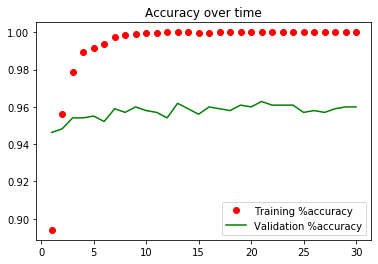

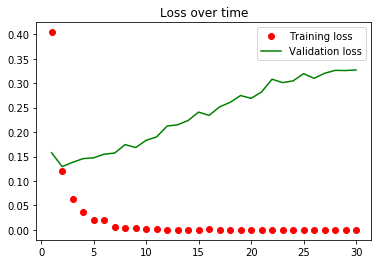

In [22]:
accuracy = history.history['acc']
validation_accuracy = history.history['val_acc']
training_loss = history.history['loss']
validation_loss = history.history['val_loss']
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, 'ro', label='Training %accuracy')
plt.plot(epochs, validation_accuracy, 'g', label='Validation %accuracy')
plt.title('Accuracy over time')
plt.legend()
plt.figure()
plt.plot(epochs, training_loss, 'ro', label='Training loss')
plt.plot(epochs, validation_loss, 'g', label='Validation loss')
plt.title('Loss over time')
plt.legend()
plt.show()

## Outcome

Achiving ~96% accuracy on validation. Training data is overfit. We have 
exceeded the generalizablility of this model.

Nice! Let's try it out on the test data.

In [23]:
test_acc, test_loss = custom_model.evaluate(
  extracted_test,
  y=y_test,
  batch_size=32)
print(test_acc)
print(test_loss)

1024/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

Running on the test data gives about ~97.1% accuracy.

## Fine tune the model.

In [24]:
base.trainable=True
combined = models.Sequential()
combined.add(base)
combined.add(custom_model)
print(combined.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50v2 (Model)           (None, 5, 5, 2048)        23564800  
_________________________________________________________________
sequential_1 (Sequential)    (None, 1)                 6553857   
Total params: 30,118,657
Trainable params: 30,073,217
Non-trainable params: 45,440
_________________________________________________________________
None


In [28]:
for layer in base.layers:
  print(layer.name + ', trainable: ' + str(layer.trainable))

input_2, trainable: False
conv1_pad, trainable: False
conv1_conv, trainable: False
pool1_pad, trainable: False
pool1_pool, trainable: False
conv2_block1_preact_bn, trainable: False
conv2_block1_preact_relu, trainable: False
conv2_block1_1_conv, trainable: False
conv2_block1_1_bn, trainable: False
conv2_block1_1_relu, trainable: False
conv2_block1_2_pad, trainable: False
conv2_block1_2_conv, trainable: False
conv2_block1_2_bn, trainable: False
conv2_block1_2_relu, trainable: False
conv2_block1_0_conv, trainable: False
conv2_block1_3_conv, trainable: False
conv2_block1_out, trainable: False
conv2_block2_preact_bn, trainable: False
conv2_block2_preact_relu, trainable: False
conv2_block2_1_conv, trainable: False
conv2_block2_1_bn, trainable: False
conv2_block2_1_relu, trainable: False
conv2_block2_2_pad, trainable: False
conv2_block2_2_conv, trainable: False
conv2_block2_2_bn, trainable: False
conv2_block2_2_relu, trainable: False
conv2_block2_3_conv, trainable: False
conv2_block2_out, tra

In [0]:
set_trainable=False
for layer in base.layers:
  if(layer.name == 'conv5_block3_1_conv'):
    set_trainable=True
  if(set_trainable):
    layer.trainable=True
  else: 
    layer.trainable=False

In [27]:
for layer in combined.layers:
  print(layer.name + ', trainable: ' + str(layer.trainable))

resnet50v2, trainable: True
sequential_1, trainable: True


In [0]:
optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-6)
combined.compile(
  loss='binary_crossentropy',
  optimizer=optimizer,
  metrics=['acc'])

In [30]:
validation_datagen = image.ImageDataGenerator()
history = combined.fit_generator(
  datagen.flow(x_train, y=y_train, batch_size=32),
  steps_per_epoch=64,
  epochs=50,
  validation_data=validation_datagen.flow(x_val, y=y_val, batch_size=32),
  validation_steps=32)

Epoch 1/50
64/64 [==============================] - 25s 384ms/step - loss: 0.7907 - acc: 0.7817 - val_loss: 0.2607 - val_acc: 0.9590
Epoch 2/50
64/64 [==============================] - 23s 364ms/step - loss: 0.7930 - acc: 0.7832 - val_loss: 0.2492 - val_acc: 0.9570
Epoch 3/50
64/64 [==============================] - 23s 367ms/step - loss: 0.7709 - acc: 0.7817 - val_loss: 0.2448 - val_acc: 0.9580
Epoch 4/50
64/64 [==============================] - 23s 365ms/step - loss: 0.7567 - acc: 0.7910 - val_loss: 0.2405 - val_acc: 0.9570
Epoch 5/50
64/64 [==============================] - 23s 367ms/step - loss: 0.7642 - acc: 0.7856 - val_loss: 0.2365 - val_acc: 0.9570
Epoch 6/50
64/64 [==============================] - 24s 371ms/step - loss: 0.7313 - acc: 0.7925 - val_loss: 0.2322 - val_acc: 0.9570
Epoch 7/50
64/64 [==============================] - 24s 374ms/step - loss: 0.6790 - acc: 0.7861 - val_loss: 0.2287 - val_acc: 0.9570
Epoch 8/50
64/64 [==============================] - 24s 369ms/step - 

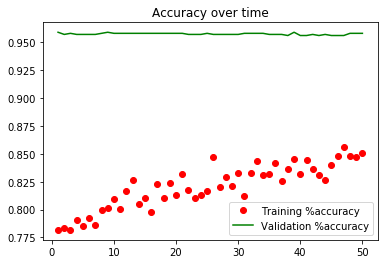

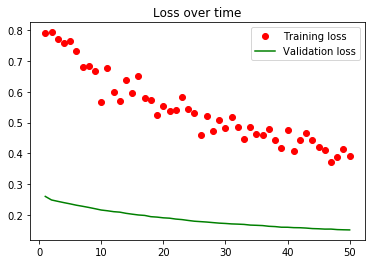

In [33]:
accuracy = history.history['acc']
validation_accuracy = history.history['val_acc']
training_loss = history.history['loss']
validation_loss = history.history['val_loss']
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, 'ro', label='Training %accuracy')
plt.plot(epochs, validation_accuracy, 'g', label='Validation %accuracy')
plt.title('Accuracy over time')
plt.legend()
plt.figure()
plt.plot(epochs, training_loss, 'ro', label='Training loss')
plt.plot(epochs, validation_loss, 'g', label='Validation loss')
plt.title('Loss over time')
plt.legend()
plt.show()

Train some more to see how far we can push this. Don't worry we gotta GPU.

In [34]:
test_loss, test_acc = combined.evaluate(
  x_test,
  y=y_test,
  batch_size=32)
print(test_acc)
print(test_loss)

1024/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

Train some more.

In [35]:
validation_datagen = image.ImageDataGenerator()
history = combined.fit_generator(
  datagen.flow(x_train, y=y_train, batch_size=32),
  steps_per_epoch=64,
  epochs=50,
  validation_data=validation_datagen.flow(x_val, y=y_val, batch_size=32),
  validation_steps=32)

Epoch 1/50
64/64 [==============================] - 26s 408ms/step - loss: 0.4146 - acc: 0.8423 - val_loss: 0.1510 - val_acc: 0.9570
Epoch 2/50
64/64 [==============================] - 24s 376ms/step - loss: 0.4076 - acc: 0.8394 - val_loss: 0.1509 - val_acc: 0.9570
Epoch 3/50
64/64 [==============================] - 24s 373ms/step - loss: 0.3866 - acc: 0.8447 - val_loss: 0.1508 - val_acc: 0.9570
Epoch 4/50
64/64 [==============================] - 24s 378ms/step - loss: 0.3661 - acc: 0.8579 - val_loss: 0.1500 - val_acc: 0.9570
Epoch 5/50
64/64 [==============================] - 24s 374ms/step - loss: 0.3935 - acc: 0.8433 - val_loss: 0.1495 - val_acc: 0.9580
Epoch 6/50
64/64 [==============================] - 24s 379ms/step - loss: 0.3572 - acc: 0.8633 - val_loss: 0.1486 - val_acc: 0.9561
Epoch 7/50
64/64 [==============================] - 24s 381ms/step - loss: 0.3907 - acc: 0.8398 - val_loss: 0.1476 - val_acc: 0.9570
Epoch 8/50
64/64 [==============================] - 24s 378ms/step - 

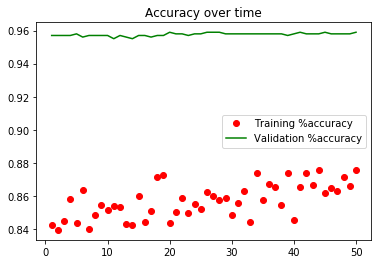

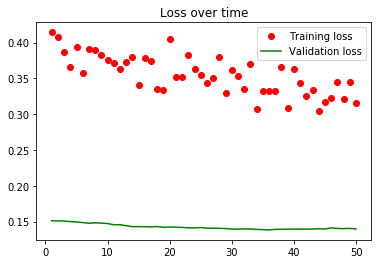

In [38]:
accuracy = history.history['acc']
validation_accuracy = history.history['val_acc']
training_loss = history.history['loss']
validation_loss = history.history['val_loss']
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, 'ro', label='Training %accuracy')
plt.plot(epochs, validation_accuracy, 'g', label='Validation %accuracy')
plt.title('Accuracy over time')
plt.legend()
plt.figure()
plt.plot(epochs, training_loss, 'ro', label='Training loss')
plt.plot(epochs, validation_loss, 'g', label='Validation loss')
plt.title('Loss over time')
plt.legend()
plt.show()

In [39]:
test_loss, test_acc = combined.evaluate(
  x_test,
  y=y_test,
  batch_size=32)
print(test_acc)
print(test_loss)

1024/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

## Conclusions

ResNet is not as simple to fine tune due to the way that the residual layers
interact. The amount of layers also makes it take much longer to train. 
The little amount of data makes training noisy. 

## Recommendations & Further Expirmentation

* Play around with learning rate. Previous expirments show that general weights
in the pretrained model can be easily lost when the learning rate is to great
Could potentially try out another optimizer. 
* Continuing to train with more epochs should ideally converge to yield an
accuracy greater that that of solely training a custom top layer.
* Further manipulate settings for the image generate to provide a larger artificial data set.
* Try another architecture for the pre-trained model base.
* Repeat the process in this notebook on the entire dataset. What improvements 
can be found?